In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
alpha = np.sqrt(5)
hbar = 1  # Setting ℏ=2
sigma = (hbar/2) * np.eye(2)  # Covariance matrix
inv_sigma = np.linalg.inv(sigma)
det_sigma = np.linalg.det(sigma)

# Create grid
x = np.linspace(-5, 5, 100)
p = np.linspace(-5, 5, 100)
X, P = np.meshgrid(x, p)
grid_points = np.stack([X.ravel(), P.ravel()], axis=-1)


# Gaussian Distributino
def GaussianDistribution(diff, det, inv_cov):
    
    # Calculate the exponent for all points at once
    exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, inv_cov, diff)
    
    return (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)

# Passing Along
def WignerCalc(diff, det, inv_cov):
    return GaussianDistribution(diff, det, inv_cov).reshape(X.shape)

c:\Users\liqiz\Desktop\Semester 3\Scientific Computing in Quantum Information Science\CV_Simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


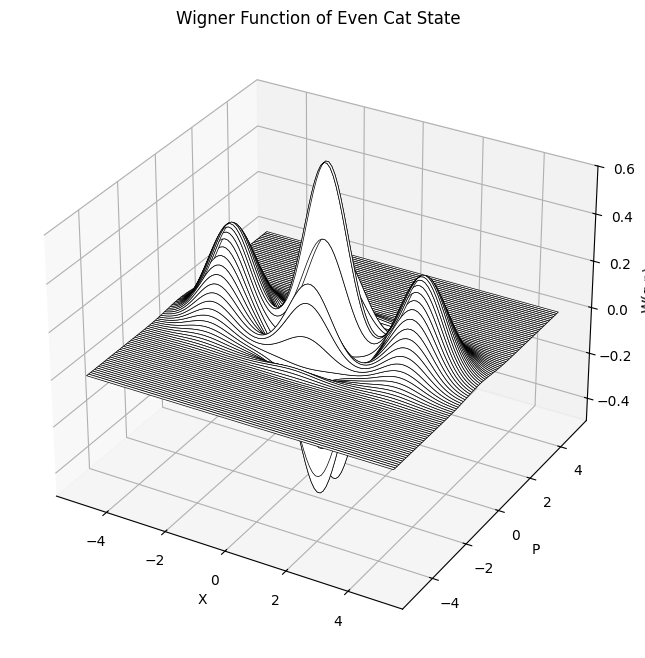

In [67]:
# Normalization factor for even cat state
Ne = 1/np.sqrt(2*(1 + np.exp(-2*np.abs(alpha)**2)))


# Define all possible combinations (including cross terms)
states = [alpha, -alpha]  # |α⟩ and |-α⟩
n_terms = len(states)


# Calculate all μ_{kl} and c_{kl}
mu = np.zeros((n_terms, n_terms, 2), dtype=complex)
d = np.zeros((n_terms, n_terms), dtype=complex)
c = np.zeros((n_terms, n_terms), dtype=complex)

for k in range(n_terms):
    for l in range(n_terms):
        # Calculate μ_{kl} 
        sum_states = states[k] + states[l]
        diff_states = states[k] - states[l]
        mu[k,l] = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*diff_states.imag,
            sum_states.imag + 1j*(-diff_states.real)
        ])
        
        # Calculate d_{kl}
        d[k,l] = ( -0.5*diff_states.imag**2 - 0.5*diff_states.real**2
                  - 1j*states[l].imag*states[k].real + 1j*states[k].imag*states[l].real)
        
        # Slightly modified c_m
        c[k,l] = np.log(Ne) + np.log(Ne) + d[k,l]

# Compute Wigner function components
W1 = np.zeros_like(X, dtype=complex)

for k in range(n_terms):
    for l in range(k, n_terms):  # Only compute upper triangle
        diff = grid_points - mu[k,l]  # Take real part for displacement
        exponent = -0.5 * np.einsum("ni,ij,nj->n...", diff , inv_sigma , diff)
        G = (1/np.sqrt(2*np.pi*(det_sigma))) * np.exp(exponent).reshape(X.shape)
        
        if k == l:  # Diagonal terms
            W1 += np.exp(c[k,l]) * G
        else:  # Cross terms (include factor of 2 for Re)
            W1 += 2 * (np.exp(c[k,l]) * G).real

# Take real part and normalize
N = 0
for k in range(n_terms):
    for l in range(k, n_terms):  # Only compute upper triangle
        if k == l:  # Diagonal terms
            N += np.exp(c[k,l])
        else:  # Cross terms (include factor of 2 for Re)
            N += 2* (np.exp(c[k,l])).real

W1 = W1/N

# Plotting
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, P, W1, rstride=1, cstride=100000, color='w', edgecolor='k', shade=False, lw=.5, alpha=1)


ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('W(q,p)')
ax.set_title('Wigner Function of Even Cat State')
ax.set_zlim(-0.5, 0.6)
plt.show()

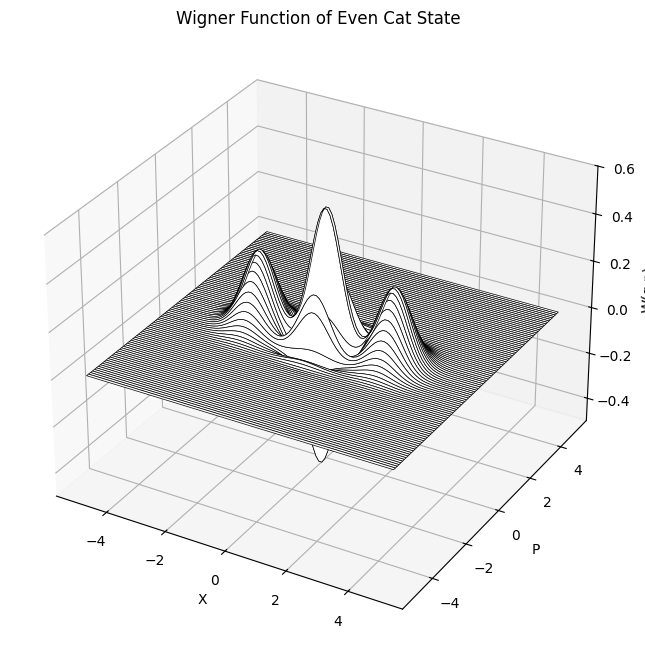

In [53]:
def wigner_even_cat(x, y, alpha):
    """
    Computes Wigner function for even cat state using the analytical formula.
    
    Args:
        x, y: Position and momentum coordinates (arrays or scalars)
        alpha: Coherent state amplitude (real or complex)
        
    Returns:
        Wigner function values
    """
    alpha = np.abs(alpha)  # Ensure we use magnitude
    prefactor = 1 / (np.pi * (1 + np.exp(-2*alpha**2)))
    
    term1 = np.exp(-2*(x - alpha)**2 - 2*y**2)
    term2 = np.exp(-2*(x + alpha)**2 - 2*y**2)
    term3 = 2 * np.exp(-2*x**2 - 2*y**2) * np.cos(4*y*alpha)
    
    return prefactor * (term1 + term2 + term3)


# Compute Wigner function
W2 = wigner_even_cat(X, P, alpha)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, P, W2, rstride=1, cstride=100000, color='w', edgecolor='k', shade=False, lw=.5, alpha=1)


ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('W(q,p)')
ax.set_title('Wigner Function of Even Cat State')
ax.set_zlim(-0.5, 0.6)
plt.show()

In [ ]:
# Fock state number
n = 2
